In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import tensorflowjs as tfjs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
# Constants
BATCH_SIZE = 64
LR = 1e-4

In [3]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [4]:
def process_match(match):
    champs = match.split(',')
    vec = []
    for i in range(10):
        champ_vec = get_champ_vec(champs[i])
        for e in champ_vec:
            vec.append(e)
    if champs[10] == 'true':
        vec.append(1)
    else:
        vec.append(0)
    return vec

In [6]:
def process_ds_element(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'float32'))

In [7]:
def get_dataset(num_games):
    tmp = []
    with open('data/matches/diamond_training_data.txt', 'r') as f:
        matches = f.read().split('\n')
        num_games = min(len(matches), num_games)
        for i in range(num_games):
            try:
                tmp.append(process_match(matches[i]))
            except:
                num_games -= 1
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_ds_element)
    ds = ds.cache()
    ds = ds.shuffle(num_games)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    print(f'Using {num_games} matches for training')
    return ds

In [8]:
ds = get_dataset(1000000000)

Using 163442 matches for training


In [9]:
# Partition Dataset
train_size = int(len(ds)*0.8)
val_size = int(len(ds)*0.1)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)
print(train_size, val_size, test_size)

2043 255 256


In [10]:
example = next(iter(train))
example

(<tf.Tensor: shape=(64, 170), dtype=float32, numpy=
 array([[0.3, 0.6, 0. , ..., 0.4, 0.6, 1. ],
        [1. , 1. , 0.6, ..., 0.9, 0. , 0. ],
        [0.1, 0.1, 0.8, ..., 0.5, 0. , 0. ],
        ...,
        [0.1, 1. , 0. , ..., 0.2, 1. , 0. ],
        [0.5, 0.8, 0.4, ..., 0.8, 0.6, 0.6],
        [0.2, 0.7, 0.1, ..., 0.8, 0.9, 0. ]], dtype=float32)>,
 <tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.], dtype=float32)>)

In [11]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=170))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [12]:
model = create_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               43776     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 85,985
Trainable params: 85,985
Non-trainable params: 0
_________________________________________________________________


In [14]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy()])

In [15]:
history = model.fit(train, validation_data=val, epochs=200)

Epoch 1/200
2043/2043 [==============================] - 3s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4964 - val_loss: 0.6927 - val_binary_accuracy: 0.4894
Epoch 2/200
2043/2043 [==============================] - 2s 990us/step - loss: 0.6927 - binary_accuracy: 0.4961 - val_loss: 0.6922 - val_binary_accuracy: 0.5053
Epoch 3/200
2043/2043 [==============================] - 2s 977us/step - loss: 0.6923 - binary_accuracy: 0.4966 - val_loss: 0.6911 - val_binary_accuracy: 0.4998
Epoch 4/200
2043/2043 [==============================] - 2s 995us/step - loss: 0.6917 - binary_accuracy: 0.4965 - val_loss: 0.6911 - val_binary_accuracy: 0.4941
Epoch 5/200
2043/2043 [==============================] - 2s 982us/step - loss: 0.6911 - binary_accuracy: 0.4968 - val_loss: 0.6900 - val_binary_accuracy: 0.5000
Epoch 6/200
2043/2043 [==============================] - 2s 983us/step - loss: 0.6904 - binary_accuracy: 0.4969 - val_loss: 0.6892 - val_binary_accuracy: 0.5013
Epoch 7/200
2043/2043 [=============

Epoch 52/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5391 - binary_accuracy: 0.6964 - val_loss: 0.5241 - val_binary_accuracy: 0.7159
Epoch 53/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5363 - binary_accuracy: 0.6988 - val_loss: 0.5216 - val_binary_accuracy: 0.7125
Epoch 54/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5324 - binary_accuracy: 0.7026 - val_loss: 0.5196 - val_binary_accuracy: 0.7129
Epoch 55/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5286 - binary_accuracy: 0.7055 - val_loss: 0.5126 - val_binary_accuracy: 0.7129
Epoch 56/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5242 - binary_accuracy: 0.7088 - val_loss: 0.5155 - val_binary_accuracy: 0.7331
Epoch 57/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.5211 - binary_accuracy: 0.7097 - val_loss: 0.5031 - val_binary_accuracy: 0.7365
Epoch 58/200
2043/2043 [================

2043/2043 [==============================] - 2s 1ms/step - loss: 0.3901 - binary_accuracy: 0.7958 - val_loss: 0.3829 - val_binary_accuracy: 0.8138
Epoch 104/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3877 - binary_accuracy: 0.7975 - val_loss: 0.3653 - val_binary_accuracy: 0.8123
Epoch 105/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3868 - binary_accuracy: 0.7978 - val_loss: 0.3653 - val_binary_accuracy: 0.8215
Epoch 106/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3827 - binary_accuracy: 0.8007 - val_loss: 0.3735 - val_binary_accuracy: 0.8215
Epoch 107/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3814 - binary_accuracy: 0.8016 - val_loss: 0.3632 - val_binary_accuracy: 0.8169
Epoch 108/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3807 - binary_accuracy: 0.8021 - val_loss: 0.3570 - val_binary_accuracy: 0.8148
Epoch 109/200
2043/2043 [=======================

Epoch 154/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3057 - binary_accuracy: 0.8417 - val_loss: 0.2906 - val_binary_accuracy: 0.8594
Epoch 155/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3044 - binary_accuracy: 0.8441 - val_loss: 0.2883 - val_binary_accuracy: 0.8516
Epoch 156/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3017 - binary_accuracy: 0.8446 - val_loss: 0.2930 - val_binary_accuracy: 0.8458
Epoch 157/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3021 - binary_accuracy: 0.8443 - val_loss: 0.2991 - val_binary_accuracy: 0.8564
Epoch 158/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.3017 - binary_accuracy: 0.8446 - val_loss: 0.2863 - val_binary_accuracy: 0.8553
Epoch 159/200
2043/2043 [==============================] - 2s 1ms/step - loss: 0.2982 - binary_accuracy: 0.8465 - val_loss: 0.2915 - val_binary_accuracy: 0.8421
Epoch 160/200
2043/2043 [=========

In [16]:
history_dict = history.history

In [17]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

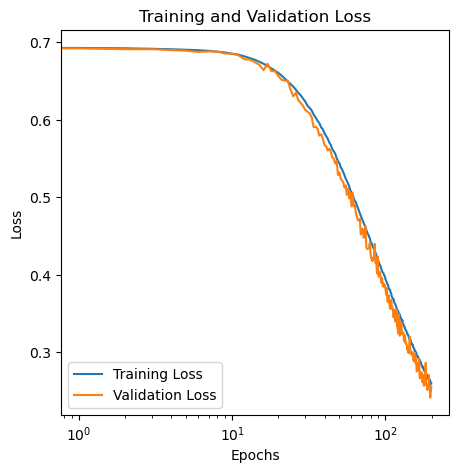

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

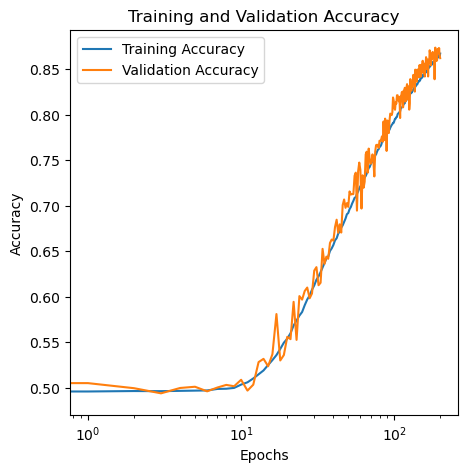

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

256/256 [==============================] - 0s 621us/step - loss: 0.2568 - binary_accuracy: 0.8655
Loss: 0.25678589940071106
Accuracy: 0.865546703338623


In [47]:
# Save the model
export_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Activation('sigmoid')
])

In [59]:
game = 'Aatrox,Nidalee,Velkoz,Jhin,Nautilus,Darius,Nocturne,Zoe,Draven,Shaco,true'
vec = process_match(game)[:-1]
out = export_model.predict([vec])
if out > 0.5:
    print('Win')
else:
    print('Loss')

1/1 [==============================] - 0s 18ms/step
Win


In [36]:
tfjs.converters.save_keras_model(export_model, 'winpredictor/public/models/master')